In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [2]:
############### Synthetic Data #############
# β = 0.005
# μ1 = 1/21 #14 days infectious
# μ2 = 1/5 #5 days (14 - 9 days)
# σ =1/5 #5 days exposed
# ω=1/9 # 9 days until emitted to hospital
# ϵ = 0.0001
# pp = 0.7
capT = 1000
# γ = 1/(80*365)
Input_H = [1500,1,0,0]
parameters = [Input_H, capT] 

In [3]:
def gillespieSEIR(initial, beta, mu1,mu2, sigma, epsilon,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]>0):
        state = np.zeros(shape= (4,4))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        rate = [R_se, R_ei, R_ir, R_is]

        Rtotal = sum(rate)
#         print(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:3])
    return event_time, np.array(pop), events, cuminf

# Decide the initial tolerance for chosen parameters

241.49722836434154
[ 0.          8.50347579  8.50347579 10.40469002 10.40469002 12.46041476
 12.46041476 15.13963381 15.13963381 17.30470444 17.30470444 17.4492824
 17.4492824  17.48721782 17.48721782 17.85656014 17.85656014 19.28128407
 19.28128407 19.63728931 19.63728931 19.9739955  19.9739955  20.75833978
 20.75833978 21.0592067  21.0592067  21.74204565 21.74204565 22.84036146
 22.84036146 23.91430627 23.91430627 24.76245542 24.76245542 27.20964138
 27.20964138 30.81206489 30.81206489 30.88032194 30.88032194 31.44980746
 31.44980746 37.21934199 37.21934199 37.64199213 37.64199213 38.3917969
 38.3917969  40.25169372 40.25169372 40.96256713]


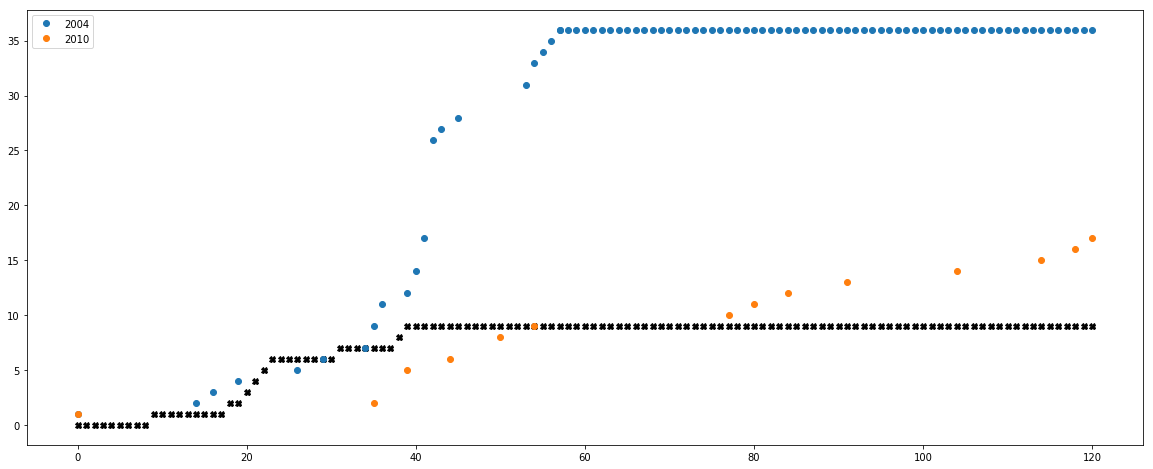

In [107]:
β = 0.008
ϵ = 0.0001
σ = 1/4

μ1 = 1/4
μ2 = 1/10

M =gillespieSEIR(parameters[0], β, μ1,μ2,σ,ϵ,  parameters[1])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))
F04 = returnerror(M, summary1[0], summary1[1])
F10 = returnerror(M, summary2[0], summary2[1])
# F10+F04

plt.figure(figsize = (20,8))
plt.plot(F10[1], F10[2], 'X',color = 'k')
plt.plot(Rec_F04, Cum_F04, 'o', label ='2004')
plt.plot(Rec_F10, Cum_F10, 'o', label = '2010')
plt.legend()
print(F10[0]+F04[0])
print(time)

In [96]:
summary1[0]

array([  0.,  14.,  16.,  19.,  26.,  29.,  34.,  35.,  36.,  39.,  40.,
        41.,  42.,  43.,  45.,  53.,  54.,  55.,  56.,  57.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
        92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102.,
       103., 104., 105., 106., 107., 108., 109., 110., 111., 112., 113.,
       114., 115., 116., 117., 118., 119., 120.])

# Perform ABC on both sets of data

In [97]:
Data_F10=pd.read_csv("../Case_data/2010_faridpur_cases.csv",sep = ',', header = 0)
Data_F04=pd.read_csv("../Case_data/2004_F_cases.csv",sep = ',', header = 0)

############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days) 
    record = [int(a - record[0]) for a in record]
    return record

Rec_F10=Spacing(Data_F10)
Rec_F04=Spacing(Data_F04)
length =  np.arange(max(Rec_F04), max(Rec_F10) +1, 1)
Rec_F04 = np.append(Rec_F04, length)
Cum_F04 = Data_F04['CumsumInf'].values
Cum_F10 = Data_F10['CumsumInf'].values
Cum_F04 = np.append(Cum_F04, max(Data_F04['CumsumInf'].values)*np.ones(len(length)))
# summary_time1
summary1 = np.array([[int(a) for a in Rec_F04], [int(b) for b in Cum_F04]])
summary2 = np.array([[int(a) for a in Rec_F10], [int(b) for b in Cum_F10]])
# Cum_F04

In [23]:
def returnerror(Gill, sumstat1, sumstat2):
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(Gill[0]):
        if ind < len(Gill[0])-1:
            time.append((Gill[0][ind], Gill[0][ind+1]))
            cuminf.append((Gill[3][ind], Gill[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = sumstat1
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = sumstat2
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(sumstat2)*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) 
    return np.linalg.norm(summary_cum-inter_cum[summary_time]), inter_t, inter_cum

In [108]:
N = 50
tol = 242
t = 0 
θ = []

β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]


θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]

t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR(parameters[0], βt, μ1t,μ2t,σt,ɛt,  parameters[1])
    F10 = returnerror(M, summary2[0], summary2[1])

    F04 = returnerror(M, summary1[0], summary1[1])
#     F10 = returnerror(M, summary2[0], summary2[1])
    Total_error = F04[0] + F10[0] 
    if Total_error <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
        print(len(θ_t), t, tol, Total_error)

        error.append(Total_error)
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 242 135.94323245033075
2 1 242 121.98599365697655
3 1 242 116.11959146581927
4 1 242 222.703144402601
5 1 242 131.00530758648858
6 1 242 193.46516074702035
7 1 242 188.22888169560701
8 1 242 224.45354993435035
9 1 242 142.38243216113403
10 1 242 153.63228613557033
11 1 242 198.23980467650208
12 1 242 182.19194346462285
13 1 242 209.64098839372468
14 1 242 142.32182384360385
15 1 242 122.51657966576386
16 1 242 153.0940127943731
17 1 242 188.00310361691754
18 1 242 158.4516585946436
19 1 242 223.57329532462975
20 1 242 120.7624986000253
21 1 242 217.95363415691247
22 1 242 159.36880963203467
23 1 242 166.8048559639717
24 1 242 231.53279526541712
25 1 242 166.47031437205757
26 1 242 177.4254355234516
27 1 242 119.3904941830494
28 1 242 166.374062272181
29 1 242 127.04552317811383
30 1 242 179.4169487660044
31 1 242 108.90111973705208
32 1 242 209.8598958494092
33 1 242 215.17333271944707
34 1 242 192.22323349137415
35 1 242 216.6944426494024
36 1 242 117.2710010760477
37 1 242 139.08

1 3 149.29410063296848 133.04510490983537
2 3 149.29410063296848 121.73067598951744
3 3 149.29410063296848 108.35503011299912
4 3 149.29410063296848 134.53532174781108
5 3 149.29410063296848 147.02174737733202
6 3 149.29410063296848 132.75916509334772
7 3 149.29410063296848 127.46902578376711
8 3 149.29410063296848 124.24548485176066
9 3 149.29410063296848 113.81215999824326
10 3 149.29410063296848 143.90749297487943
11 3 149.29410063296848 137.785397847471
12 3 149.29410063296848 122.73784434802623
13 3 149.29410063296848 141.9206019356894
14 3 149.29410063296848 138.1519943374136
15 3 149.29410063296848 127.24159790301258
16 3 149.29410063296848 137.00562451861464
17 3 149.29410063296848 147.56864487315045
18 3 149.29410063296848 137.86290541049152
19 3 149.29410063296848 123.04718119845992
20 3 149.29410063296848 143.56353749966001
21 3 149.29410063296848 142.97366947287423
22 3 149.29410063296848 127.6657039649463
23 3 149.29410063296848 145.9882446562701
24 3 149.29410063296848 14

50 4 137.73048189947363 135.75353655644113
[[1.33086416e-02 4.48082075e-04 5.37764072e-01 5.46178871e-02
  1.41994059e-01]
 [1.16751753e-02 4.32587573e-04 4.10689826e-01 1.80666794e-01
  5.50854081e-01]
 [2.34095262e-02 3.58339867e-04 5.37588125e-01 2.41467689e-01
  3.93893280e-02]
 [2.32285700e-02 3.58363923e-04 2.91242404e-01 2.41535250e-01
  1.66273641e-01]
 [6.12632912e-03 4.60229080e-04 2.52953125e-01 2.41754078e-01
  7.37115811e-02]
 [4.32456449e-02 3.90922660e-04 3.83202464e-01 2.41480757e-01
  1.37863728e-01]
 [7.21599126e-03 5.16723848e-04 5.37501424e-01 5.55878852e-02
  1.37657273e-01]
 [4.36580813e-02 4.41898367e-04 2.91077212e-01 1.80823379e-01
  7.42803245e-02]
 [5.30418498e-02 4.98016407e-04 2.52641943e-01 3.27513683e-02
  5.50729718e-01]
 [7.13271518e-03 4.53137664e-04 2.58045505e-01 2.41586305e-01
  5.50873384e-01]
 [1.91210831e-02 3.62527735e-04 5.37573473e-01 2.41526666e-01
  3.93746753e-02]
 [4.31544810e-02 4.85073143e-04 5.37628751e-01 2.41568507e-01
  1.57930080e-0

In [110]:
Input_H

[1500, 1, 0, 0]

In [109]:
np.save('theta_F_combined1', θ)
np.save('tols_F_combined1', tols)

In [12]:
# np.save('theta_SEIR', θ)
# np.save('tols_SEIR', tols)
len(θ[0][:,1])

100

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


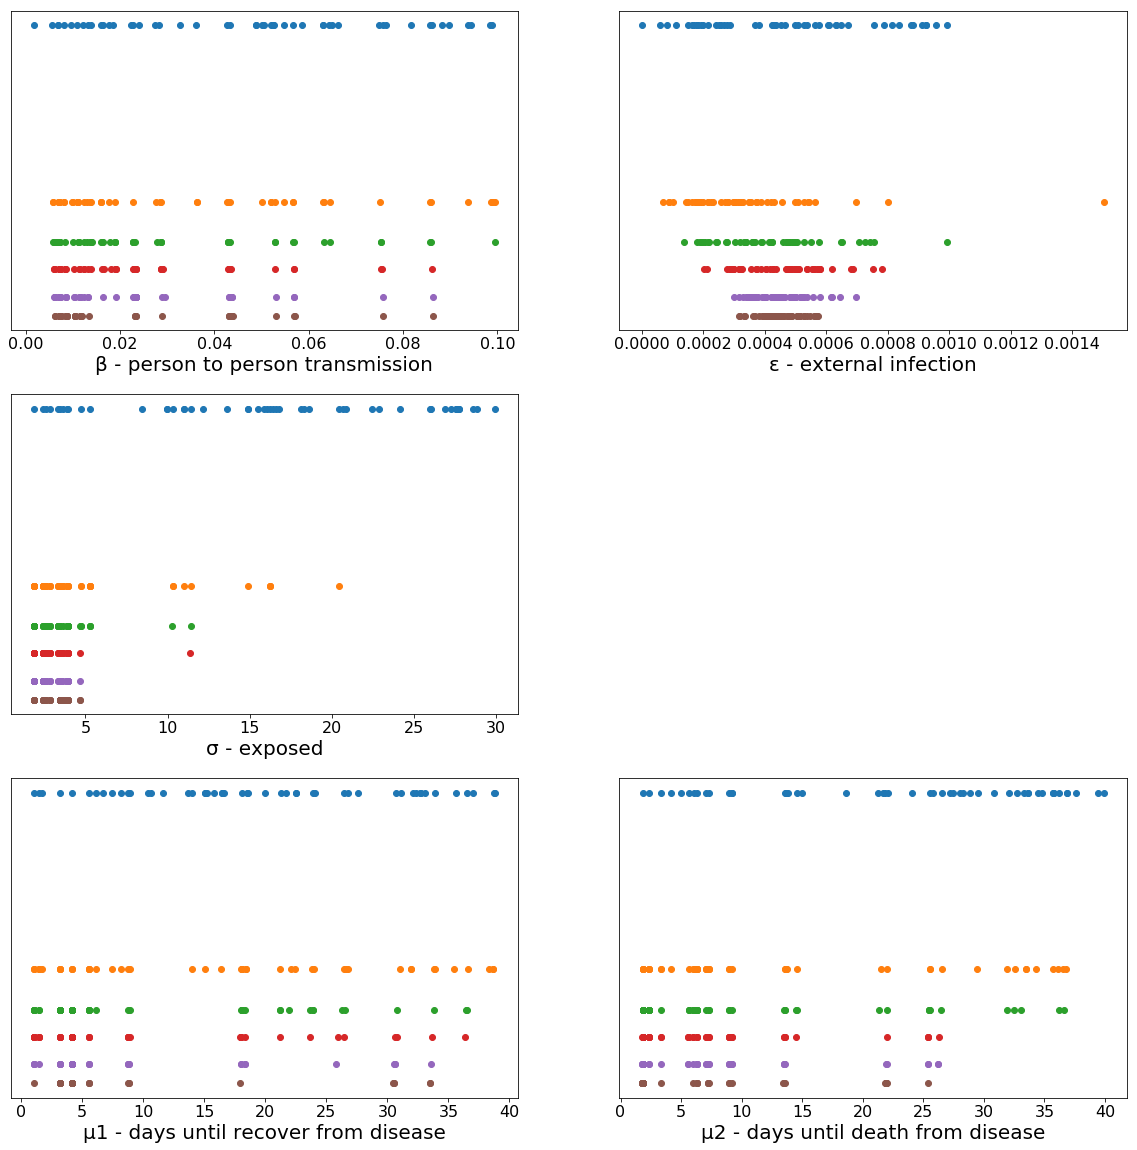

In [111]:
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(N), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(N), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(N), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(N), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(N), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)
    
#     tol -=1

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 9 Text xticklabel objects>)

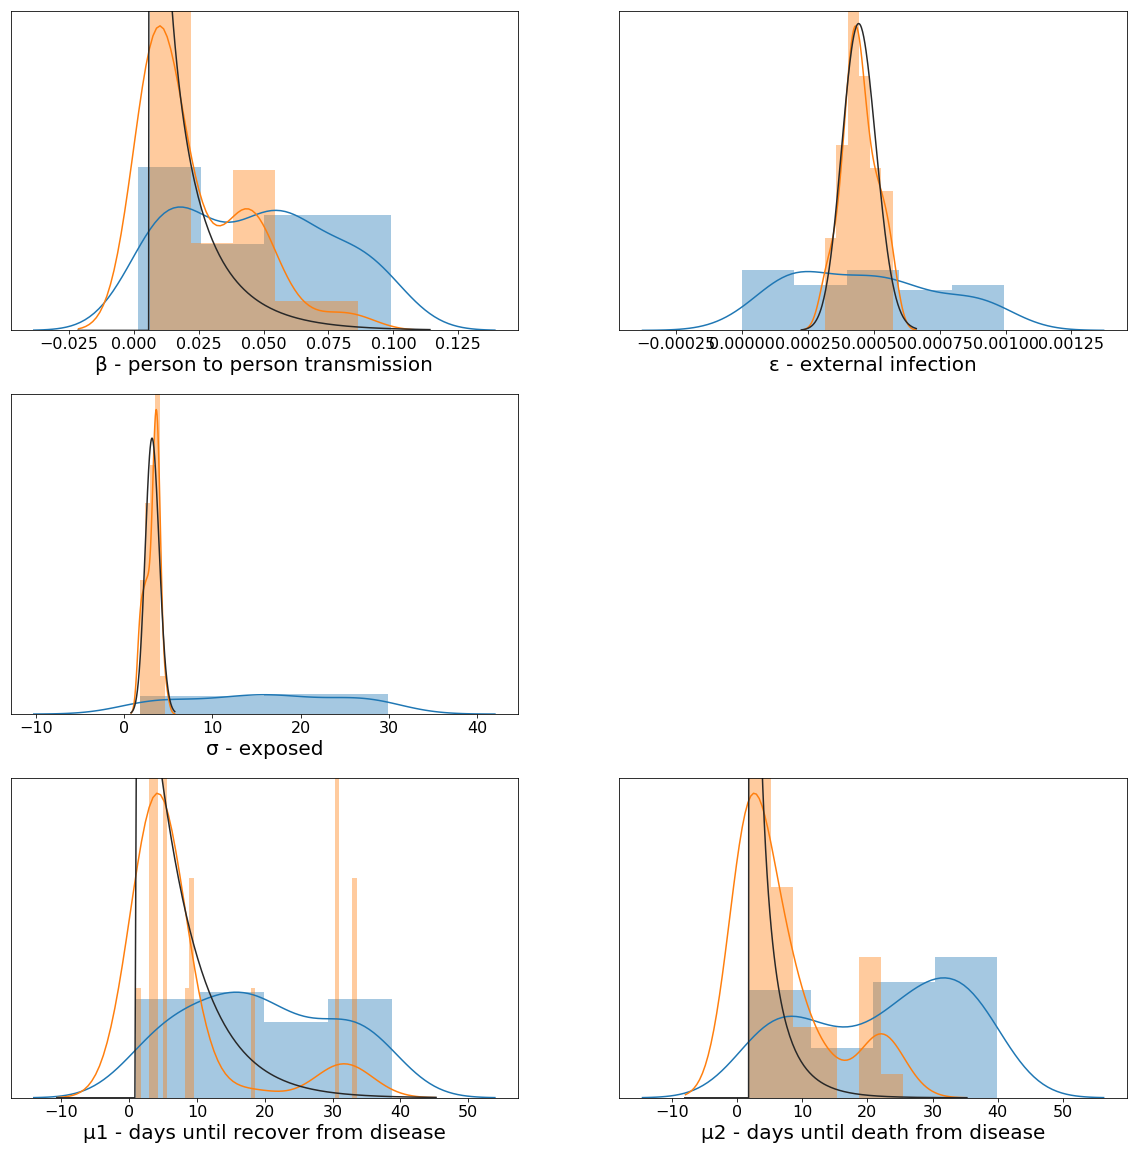

In [112]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
# plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(100), 'o' )
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
#     plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

In [113]:
a_β, loc_β, scale_β = stats.gamma.fit(θ[5][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[5][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[5][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[5][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[5][:,4]])

# Test the combined model


In [114]:
summary1

array([[  0,  14,  16,  19,  26,  29,  34,  35,  36,  39,  40,  41,  42,
         43,  45,  53,  54,  55,  56,  57,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120],
       [  1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  14,  17,  26,
         27,  28,  31,  33,  34,  35,  36,  36,  36,  36,  36,  36,  36,
         36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,
         36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,
         36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,
         36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,  36,
         36,  36,  36,  36,  36,  36]])

In [115]:
timing = []
cumulative = []
Num_sim = 1000

for k in range(Num_sim):

    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR(parameters[0], beta, mu1,mu2,
                          sigma,epsilon,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    #     print(max_inf, max_time, βt, ɛt)


    
    
    summary_time2 = summary2[0]
    #         print(summary_time, max(summary_time[0]), max_time)
    summary_cum2 = summary2[1]
    if max_time> max(summary_time2):
        length1 =  np.arange(max(summary_time2), max_time +1, 1)
        summary_time2 = np.append(summary_time2, length1)
    #         print(summary_time, len( length1))
        summary_cum2 = np.append(summary_cum2, max(summary2[1])*np.ones(len(length1 )))
    #         print(summary_cum)
    if max_time < max(summary_time2):
        length2 = np.arange(max_time, max(summary_time2)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    summary_time1 = summary1[0]
    #         print(summary_time, max(summary_time[0]), max_time)
    summary_cum1 = summary1[1]
    if max_time> max(summary_time1):
        length1 =  np.arange(max(summary_time1), max_time +1, 1)
        summary_time1 = np.append(summary_time1, length1)
    #         print(summary_time, len( length1))
        summary_cum1 = np.append(summary_cum1, max(summary1[1])*np.ones(len(length1 )))
    #         print(summary_cum)
    if max_time < max(summary_time1):
        length2 = np.arange(max_time, max(summary_time1)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

    inter_t = np.arange(0, np.maximum(summary_time1[-1], summary_time2[-1]) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    timing.append(inter_t)
    cumulative.append(inter_cum)

In [116]:
summary_time1
length =  np.arange(max(summary_time1), max(summary_time2) +1, 1)
summary_time1 = np.append(summary_time1, length)
summary_cum1 = np.append(summary_cum1, max(summary1[1])*np.ones(len(length)))
summary_time1

array([  0,  14,  16,  19,  26,  29,  34,  35,  36,  39,  40,  41,  42,
        43,  45,  53,  54,  55,  56,  57,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 120])

In [117]:
len_outbreak = np.maximum(summary_time1[-1],summary_time2[-1])

(0, 100)

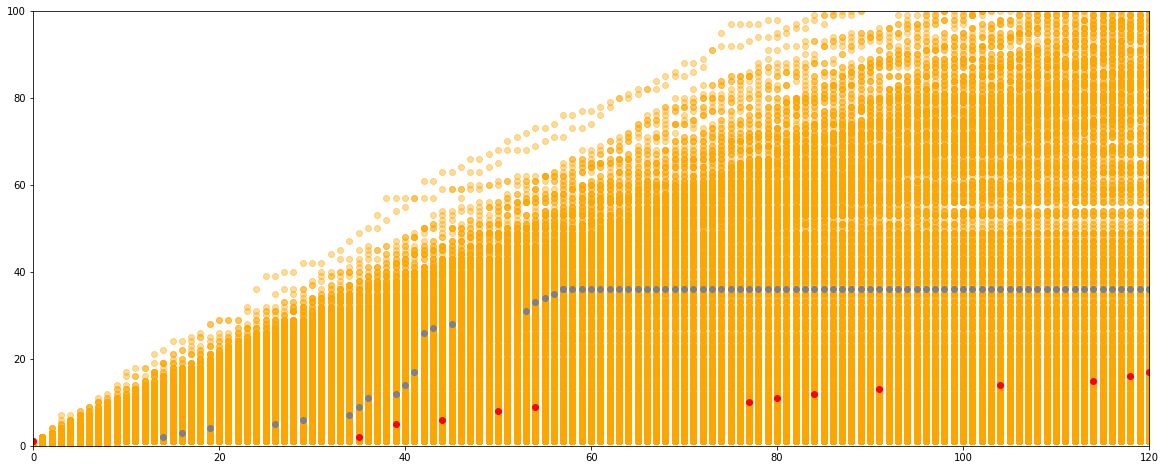

In [118]:
plt.figure(figsize = (20,8))
for j in range(Num_sim):
    plt.plot(timing[j], cumulative[j], 'o', color = 'orange', alpha = 0.4)

plt.plot(summary_time1, summary_cum1, 'o', color = 'grey', label ='2004')
plt.plot(summary_time2, summary_cum2, 'o', color = 'red', label = '2010')
plt.xlim([0,len_outbreak])
plt.ylim([0,100])


In [119]:
sun_cum = np.zeros(len_outbreak)
for k in range(len_outbreak):
    for j in range(Num_sim):
        if timing[j][-1]<k:
            sun_cum[k] +=0
        else:
            sun_cum[k] += cumulative[j][k]

In [129]:
cumulative = np.array(cumulative)
mat = np.zeros(shape=(Num_sim, len_outbreak+1))
for k in range(Num_sim):
    mat[k,:] = cumulative[k][:len_outbreak+1]
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

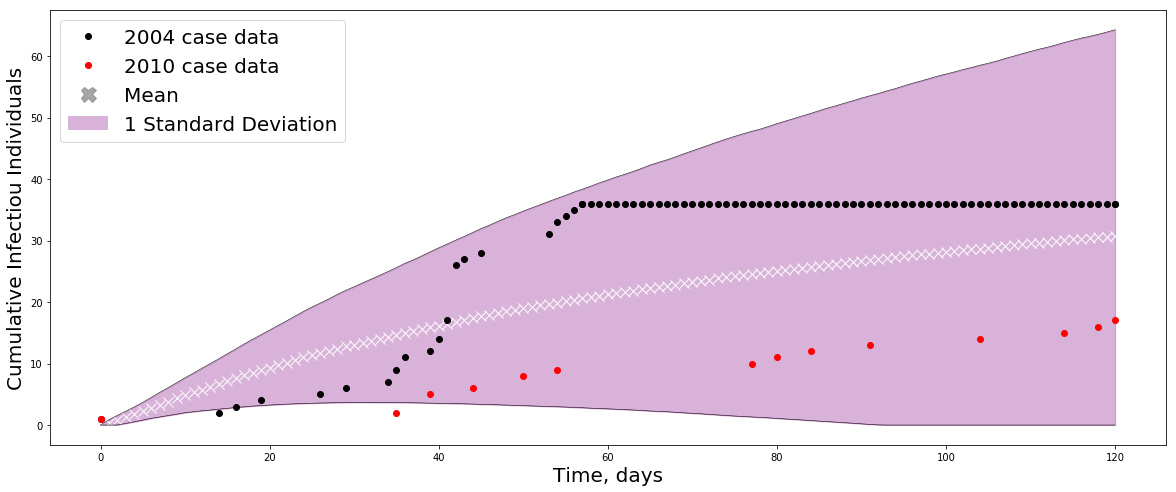

In [134]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(len_outbreak+1), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 2, color = '#fdfdfe', label = 'Mean')
plt.plot(range(len_outbreak+1), (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(len_outbreak+1), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(range(len_outbreak+1),  (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0), 1, alpha=0.3, color = 'purple')
true1, = ax.plot(summary_time1, summary_cum1, 'o', color = 'black', label = '2004 case data')
true2, = ax.plot(summary_time2, summary_cum2, 'o', color = 'red', label = '2010 case data')

# leg = ax.legend(fontsize = 20)
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)
patch = mpatches.Patch(facecolor='purple', alpha=0.3, linewidth=0, label = '1 Standard Deviation')
blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 0.2,  label='Mean')
plt.legend(handles=[true1, true2,blue_line, patch], fontsize = 20)

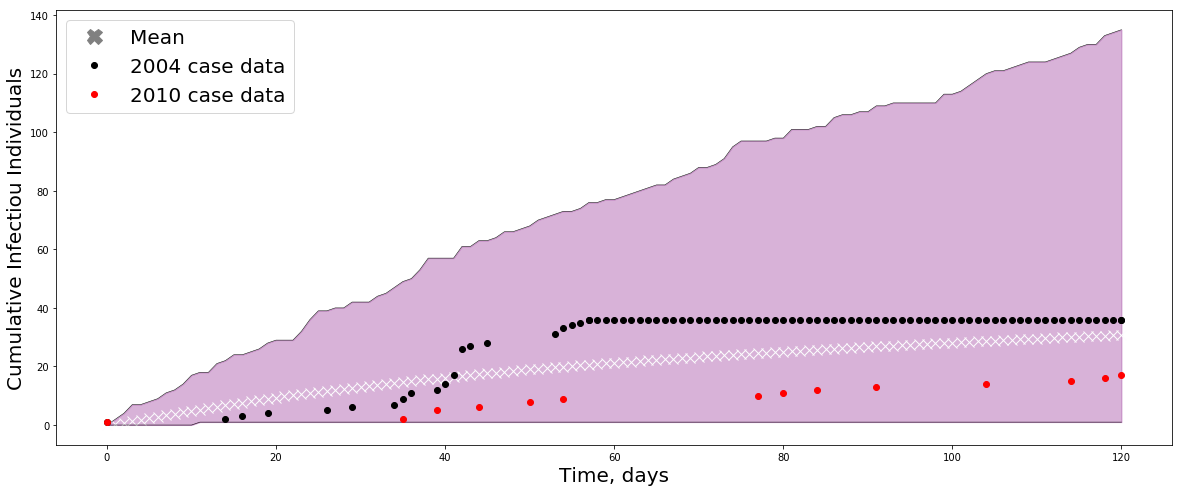

In [122]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(len_outbreak+1), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mean')
plt.plot(range(len_outbreak+1), (np.max(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(len_outbreak+1), np.min(mat, axis = 0),color ='k', lw=0.5)
plt.fill_between(range(len_outbreak+1),  (np.max(mat, axis = 0)), (np.min(mat, axis = 0)), 1, alpha=0.3, color = 'purple')
true1, = ax.plot(summary_time1, summary_cum1, 'o', color = 'black', label = '2004 case data')
true2, = ax.plot(summary_time2, summary_cum2, 'o', color = 'red', label = '2010 case data')

# leg = ax.legend(fontsize = 20)
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)

blue_line = mlines.Line2D([], [], color='grey', marker='X',
                          markersize=15, linestyle = '', linewidth = 2,  label='Mean')
plt.legend(handles=[blue_line, true1, true2], fontsize = 20)

# Error between mean and data

In [123]:
def returnerror_time(timestep, cum, sumstat1, sumstat2):
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(timestep):
        if ind < len(timestep)-1:
            time.append((timestep[ind], timestep[ind+1]))
            cuminf.append((cum[ind], cum[ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = sumstat1
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = sumstat2
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(sumstat2)*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) 
    return np.linalg.norm(summary_cum-inter_cum[summary_time]), inter_t, inter_cum

138.65446136748167

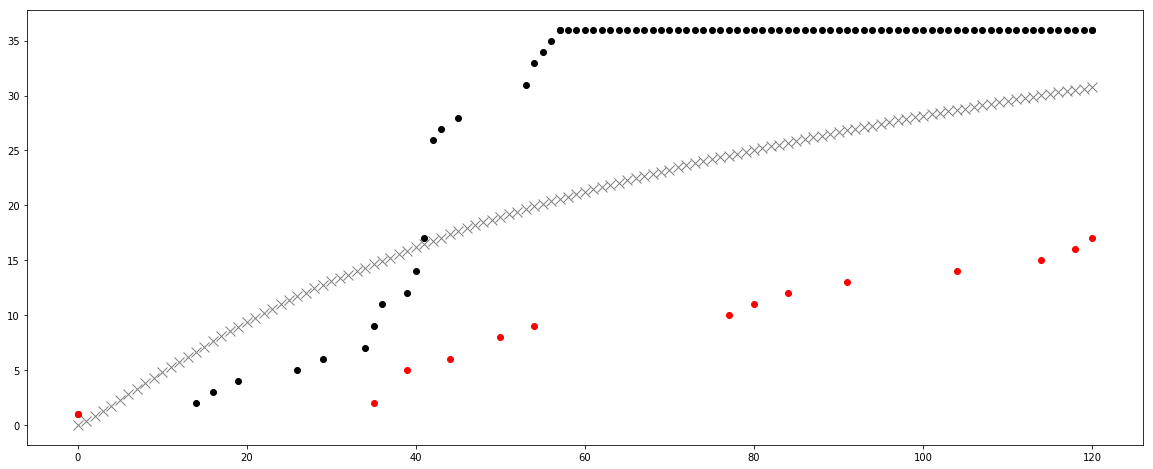

In [124]:
plt.figure(figsize = (20,8))
plt.plot(range(len_outbreak +1), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = 'grey', label = 'Mean')

plt.plot(summary_time1, summary_cum1, 'o', color = 'black')
plt.plot(summary_time2, summary_cum2, 'o', color = 'red')

F04 = returnerror_time(range(len_outbreak+1), np.mean(mat, axis = 0), summary_time1,summary_cum1)[0]
F10 = returnerror_time(range(len_outbreak+1), np.mean(mat, axis = 0), Rec_F10, Data_F10['CumsumInf'].values)[0]

error = F04 + F10
error